In [ ]:
#baixando o dataset e extraindo os arquivos
!rm -rf /content/*
!wget https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
!unzip /content/cats_and_dogs_filtered.zip
!rm /content/cats_and_dogs_filtered.zip
!mv /content/cats_and_dogs_filtered /content/dataset
!rm /content/dataset/vectorize.py

In [ ]:
import numpy as np
np.random.seed(1)
import tensorflow as tf
tf.random.set_seed(2)

import requests
from PIL import Image
from io import BytesIO

import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

sns.set()

In [ ]:
train_folder = '/content/dataset/train'
val_folder = '/content/dataset/validation'

In [ ]:
train_datagen = ImageDataGenerator(
    horizontal_flip=True,
    rotation_range=20,
    brightness_range=[0.5,1.0],
    height_shift_range=0.2,
    preprocessing_function = tf.keras.applications.mobilenet_v2.preprocess_input
)

val_datagen = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.mobilenet_v2.preprocess_input
)

In [ ]:
train_it = train_datagen.flow_from_directory(
    train_folder,
    target_size=(224,224),
    class_mode='binary',
    batch_size=32,
    shuffle=False)

val_it = val_datagen.flow_from_directory(
    val_folder,
    target_size=(224,224),
    class_mode='binary',
    batch_size=32,
    seed=1)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
label_map = {v : k for k, v in train_it.class_indices.items()}
label_map

{0: 'cats', 1: 'dogs'}

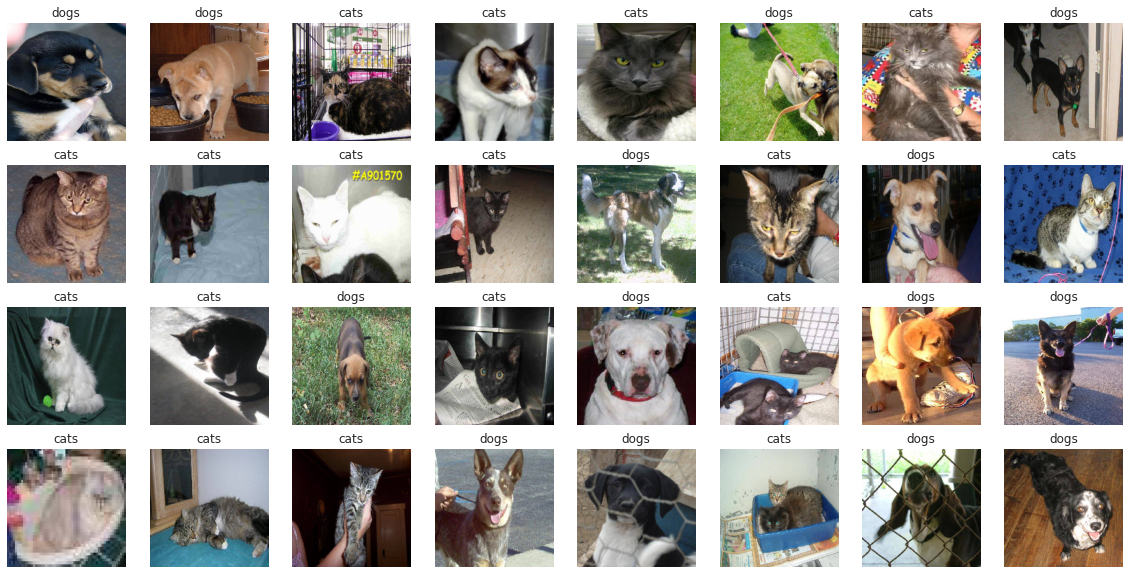

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=8, figsize=(20, 10))

for img, label, ax in zip(val_it[0][0], val_it[0][1], axes.flat):
    img = img*0.5 + 0.5 #para colocar o range entre 0-1
    ax.imshow(img)
    ax.set_title(f'{label_map[label]}')
    ax.axis('off')

plt.show()

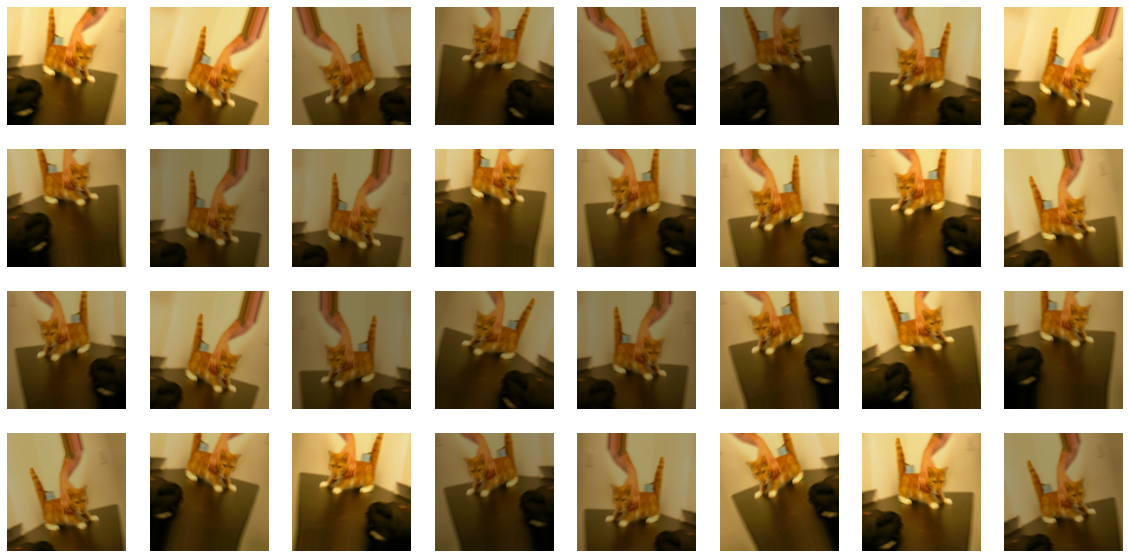

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=8, figsize=(20, 10))

for ax in axes.flat:
    img = train_it[0][0][0]*0.5 + 0.5 #para colocar o range entre 0 e 1
    ax.imshow(img)
    ax.axis('off')

plt.show()

In [ ]:
mobilenetv2 = MobileNetV2(input_shape=(224, 224, 3), include_top=False, pooling='avg')
mobilenetv2.trainable = False
mobilenetv2.summary()

9412608/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
________________

In [ ]:
model = Sequential()
model.add(mobilenetv2)
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(train_it, epochs=3, validation_data=val_it)

Epoch 1/3
63/63 [==============================] - 34s 539ms/step - loss: 0.3063 - accuracy: 0.8820 - val_loss: 0.1289 - val_accuracy: 0.9720
Epoch 2/3
63/63 [==============================] - 33s 523ms/step - loss: 0.1376 - accuracy: 0.9595 - val_loss: 0.0917 - val_accuracy: 0.9830
Epoch 3/3
63/63 [==============================] - 33s 527ms/step - loss: 0.0999 - accuracy: 0.9710 - val_loss: 0.0886 - val_accuracy: 0.9780


In [ ]:
url_images = ['https://images.unsplash.com/photo-1574144611937-0df059b5ef3e?ixlib=rb-1.2.1&q=80&fm=jpg&crop=entropy&cs=tinysrgb&dl=loan-7AIDE8PrvA0-unsplash.jpg&w=640',
              'https://images.unsplash.com/photo-1561037404-61cd46aa615b?ixlib=rb-1.2.1&q=80&fm=jpg&crop=entropy&cs=tinysrgb&dl=victor-grabarczyk-N04FIfHhv_k-unsplash.jpg&w=640',
              'https://images.unsplash.com/photo-1573435567032-ff5982925350?ixlib=rb-1.2.1&q=80&fm=jpg&crop=entropy&cs=tinysrgb&dl=tran-mau-tri-tam-7QjU_u2vGDs-unsplash.jpg&w=640', 
              'https://images.unsplash.com/photo-1585849847025-256a1488e653?ixlib=rb-1.2.1&q=80&fm=jpg&crop=entropy&cs=tinysrgb&dl=tatiana-rodriguez-V2k_xw-miO0-unsplash.jpg&w=640']

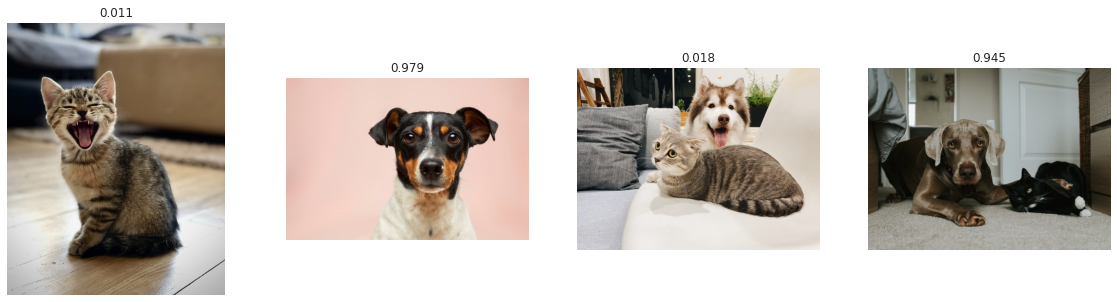

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))

for ax, url_image in zip(axes.flat, url_images):

    response = requests.get(url_image)
    img_original = Image.open(BytesIO(response.content))

    img = np.array(img_original.resize((224, 224)))
    img = tf.keras.applications.mobilenet_v2.preprocess_input(img)
    img = img.reshape(1, 224, 224, 3)
    pred = model.predict(img)[0][0]
    
    ax.imshow(img_original)
    ax.set_title(f'{pred:.3f}')
    ax.axis('off')
    
plt.show()